In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [80]:
import sys
# メモリ確認用 https://qiita.com/AnchorBlues/items/883790e43417640140aa
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                  data_ex|20133087610|
|                 out_eval|  13115264|
|                  out_sub|  24116896|
|                out_valid|  13115264|
|                     subm| 366881216|
|                     test| 366881216|
|                    train|19781208258|
|                   y_pred|   6829856|


参考：
* **for_Japanese_beginner(with WRMSSE in LGBM))**  https://www.kaggle.com/girmdshinsei/for-japanese-beginner-with-wrmsse-in-lgbm#data%E5%8A%A0%E5%B7%A5-(data-transform)
* **Back to (predict) the future - Interactive M5 EDA**  https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

# データの読み込み

In [148]:
data = pd.read_csv('./data/sales_train_evaluation.csv')
cal = pd.read_csv('./data/calendar.csv')
pri = pd.read_csv('./data/sell_prices.csv')

In [149]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [165]:
pri.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [166]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


# データの整形

## submission 部分(d1942 - d1969)を追加

In [154]:
tmp = []
for n in list(range(1942, 1970)):
    tmp.append(f"d_{n}")
data[tmp]=0

In [157]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## とりあえず data を "説明変数-販売数" の形にする

In [158]:
data_tr = pd.melt(data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='date_id', value_name='num')

## calendar, price 情報を追加

In [160]:
data_tr = pd.merge(data_tr, cal, how = 'left', left_on = ['date_id'], right_on = ['d'])

In [161]:
data_tr = data_tr.merge(pri, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [162]:
data_tr.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date_id,num,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN


In [167]:
# 取扱期間外なら price は nan
data_tr["sell_price"].isnull().sum()

12299413

## いらん情報を削減

### sell_price が nan な行

取扱期間外と思われる

In [168]:
data_ex = data_tr.dropna(subset=['sell_price'])

In [169]:
del data
del data_tr

In [170]:
del cal
del pri

### weekday, d いらん

In [172]:
data_ex.drop(["weekday", "d"], axis=1, inplace=True)

In [173]:
# backup
data_ex.to_csv("./data/backup/data_ex.csv", index=False)

## 学習できるように数値にする

In [3]:
# data_ex = pd.read_csv('./data/backup/data_ex.csv')

/home/usrs/tack/miniconda/miniconda3/envs/moji110/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### "dept_id", "cat_id", "store_id", "state_id" を one-hot encodeing

In [4]:
# "dept_id", "cat_id", "store_id", "state_id" を one-hot encodeing
data_ex = pd.get_dummies(data_ex, columns=["dept_id", "cat_id", "store_id", "state_id"])

In [5]:
pd.set_option('display.max_columns', 50)

### event をどうにかする

#### event_name を Label-encoding

In [7]:
print(data_ex.isnull().any())

id                     False
item_id                False
date_id                False
num                    False
date                   False
wm_yr_wk               False
wday                   False
month                  False
year                   False
event_name_1            True
event_type_1            True
event_name_2            True
event_type_2            True
snap_CA                False
snap_TX                False
snap_WI                False
sell_price             False
dept_id_FOODS_1        False
dept_id_FOODS_2        False
dept_id_FOODS_3        False
dept_id_HOBBIES_1      False
dept_id_HOBBIES_2      False
dept_id_HOUSEHOLD_1    False
dept_id_HOUSEHOLD_2    False
cat_id_FOODS           False
cat_id_HOBBIES         False
cat_id_HOUSEHOLD       False
store_id_CA_1          False
store_id_CA_2          False
store_id_CA_3          False
store_id_CA_4          False
store_id_TX_1          False
store_id_TX_2          False
store_id_TX_3          False
store_id_WI_1 

In [8]:
data_ex.fillna("nan", inplace=True)

In [9]:
oe = OrdinalEncoder()
encoded = oe.fit_transform(data_ex[['event_name_1','event_name_2']].values)
decoded = oe.inverse_transform(encoded)

In [10]:
tmp = pd.DataFrame(encoded, columns=['event_name_1','event_name_2']).astype('int')
data_ex.update(tmp)

#### event-type をone-hot encoding

In [12]:
data_ex = pd.get_dummies(data_ex, columns=["event_type_1", "event_type_2"])

In [13]:
data_ex["event_type_1_nan"] = data_ex["event_type_1_nan"] & data_ex["event_type_2_nan"]
data_ex["event_type_1_Cultural"] = data_ex["event_type_1_Cultural"] | data_ex["event_type_2_Cultural"]
data_ex["event_type_1_Religious"] = data_ex["event_type_1_Religious"] | data_ex["event_type_2_Religious"]

In [14]:
data_ex.drop(["event_type_2_Cultural", "event_type_2_Religious", "event_type_2_nan"], axis=1, inplace=True)

### date_id を数値化

In [15]:
data_ex["date_id"] = data_ex["date_id"].str.replace('d_', '')
data_ex["date_id"] = data_ex["date_id"].astype("int")

### date を 日-day に

In [19]:
data_ex["date"] = data_ex["date"].str[-2:]
data_ex["date"] = data_ex["date"].astype("int")

### item_id を数値化

In [23]:
encoded = oe.fit_transform(data_ex[['item_id']].values)
decoded = oe.inverse_transform(encoded)

In [24]:
data_ex["item_id"] = encoded
data_ex["item_id"] = data_ex["item_id"].astype('int')

In [ ]:
# data_ex["id"] = data_ex["id"].str.replace('evaluation', 'validation')

## 基本的な整形完了

In [97]:
data_ex

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,...,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan
0,HOBBIES_1_008_CA_1_validation,1444,1,12,29,11101,1,1,2011,30,...,0,0,1,0,0,0,0,0,0,1
1,HOBBIES_1_009_CA_1_validation,1445,1,2,29,11101,1,1,2011,30,...,0,0,1,0,0,0,0,0,0,1
2,HOBBIES_1_010_CA_1_validation,1446,1,0,29,11101,1,1,2011,30,...,0,0,1,0,0,0,0,0,0,1
3,HOBBIES_1_012_CA_1_validation,1448,1,0,29,11101,1,1,2011,30,...,0,0,1,0,0,0,0,0,0,1
4,HOBBIES_1_015_CA_1_validation,1451,1,4,29,11101,1,1,2011,30,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,FOODS_3_823_WI_3_evaluation,1432,1969,0,19,11621,2,6,2016,16,...,0,1,0,0,1,1,0,0,1,0
47735393,FOODS_3_824_WI_3_evaluation,1433,1969,0,19,11621,2,6,2016,16,...,0,1,0,0,1,1,0,0,1,0
47735394,FOODS_3_825_WI_3_evaluation,1434,1969,0,19,11621,2,6,2016,16,...,0,1,0,0,1,1,0,0,1,0
47735395,FOODS_3_826_WI_3_evaluation,1435,1969,0,19,11621,2,6,2016,16,...,0,1,0,0,1,1,0,0,1,0


In [95]:
tmp = pd.concat([   data_ex[1941 >= data_ex["date_id"]]["id"], 
                    data_ex[1942 <= data_ex["date_id"]]["id"].str.replace("validation", "evaluation")])
data_ex["id"] = tmp
del tmp

In [98]:
# backup
data_ex.to_csv('./data/backup/data_ex2.csv', index=False)

# train data と test data の生成

* d_1 - d_1913 が train 用
* d_1914 - d_1941 が test 用
* d_1942 - d_1969 が submission 用
らしいよ

In [3]:
data_ex = pd.read_csv('./data/backup/data_ex2.csv')

In [4]:
train = data_ex[data_ex["date_id"] <= 1913]
test = data_ex[(1914 <= data_ex["date_id"]) & (data_ex["date_id"] <= 1941)]
subm = data_ex[1942 <= data_ex["date_id"]]
del data_ex

In [5]:
pd.options.display.max_columns = 100
subm.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan
46881677,HOBBIES_1_001_CA_1_evaluation,1437,1942,0,23,11617,3,5,2016,30,4,0,0,0,8.38,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881678,HOBBIES_1_002_CA_1_evaluation,1438,1942,0,23,11617,3,5,2016,30,4,0,0,0,3.97,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881679,HOBBIES_1_003_CA_1_evaluation,1439,1942,0,23,11617,3,5,2016,30,4,0,0,0,2.97,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881680,HOBBIES_1_004_CA_1_evaluation,1440,1942,0,23,11617,3,5,2016,30,4,0,0,0,4.64,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881681,HOBBIES_1_005_CA_1_evaluation,1441,1942,0,23,11617,3,5,2016,30,4,0,0,0,2.88,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### Memo
* id ... id、商品、地域、店舗などの情報を持つ
* item_id ... 商品の id を label-encoding したもの
* date_id ... calendar.csv の "d" に相当。1日目からの連番
* num ... 売れた商品の数。目的変数。
* date ... 年/月/日 の日。
* wm_yr_wk ... "1" + "year" + "week"
* wday ... 曜日
* month ... 年/月/日 の月。
* year ... 年/月/日 の年。
* eventname ... event の名前を label-encoding したもの

# 学習・評価しよう

## 特徴の指定

In [6]:
features = [
    'item_id', 
    'date_id', 
    'date', 
    'wm_yr_wk', 
    'wday', 
    'month', 
    'year', 
    'event_name_1', 
    'event_name_2', 
    'snap_CA', 
    'snap_TX', 
    'snap_WI', 
    'sell_price', 
    'dept_id_FOODS_1', 
    'dept_id_FOODS_2', 
    'dept_id_FOODS_3', 
    'dept_id_HOBBIES_1', 
    'dept_id_HOBBIES_2', 
    'dept_id_HOUSEHOLD_1', 
    'dept_id_HOUSEHOLD_2', 
    'cat_id_FOODS', 
    'cat_id_HOBBIES', 
    'cat_id_HOUSEHOLD', 
    'store_id_CA_1', 
    'store_id_CA_2', 
    'store_id_CA_3', 
    'store_id_CA_4', 
    'store_id_TX_1', 
    'store_id_TX_2', 
    'store_id_TX_3', 
    'store_id_WI_1', 
    'store_id_WI_2', 
    'store_id_WI_3', 
    'state_id_CA', 
    'state_id_TX', 
    'state_id_WI', 
    'event_type_1_Cultural', 
    'event_type_1_National', 
    'event_type_1_Religious', 
    'event_type_1_Sporting', 
    'event_type_1_nan']

## params

In [7]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.01,
    'bagging_fraction': 0.96,
    'bagging_freq': 10, 
    'colsample_bytree': 0.92,
    'max_depth': 12,
    'min_data_in_leaf': 12,
    'lambda_l1': 0.052224,
    'lambda_l2': 0.000475,
    'num_leaves': 60,
    'device':'gpu'}

* objective ... 目的関数。default: regression(回帰)。他にbinary, multiclass
* n_jobs ... スレッド数。
* learning_rate ... default: 0.1
* bagging_fraction ... baggingで選択されるサンプルの割合。default: 1.0
* bagging_freq ... n 回に一回サンプリングされたデータが更新されるらしい
    * バギングとは、 ... 独立に多数の弱学習器を作って「多数決を取ったものを出力とする」ような手法らしい
* colsample_bytree ... 例えば、0.8なら,訓練前に特徴量の80%を選択する。高速化、Overfitting対策。

## train / test set

In [8]:
train_set = lgb.Dataset(train[features], train['num'])
test_set = lgb.Dataset(test[features], test['num'])

# training

* num_boost_round ... num_iterations, num_round とかと同じらしい。
* early_stopping_rounds ... 評価用データのスコアが頭打ちになったら学習を打ち切る

In [9]:
st = time.time()
results={}
num_boost_round = 100000
early_stopping_rounds = 50
model = lgb.train(  params,
                    train_set, 
                    num_boost_round = num_boost_round,
                    early_stopping_rounds = early_stopping_rounds, 
                    valid_sets = [train_set, test_set], 
                    valid_names=["train", "test"], 
                    verbose_eval = 100,
                    evals_result=results)
print(f"time: {time.time()-st:.2f} [sec]")

/home/usrs/tack/miniconda/miniconda3/envs/lgb/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/usrs/tack/miniconda/miniconda3/envs/lgb/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/usrs/tack/miniconda/miniconda3/envs/lgb/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation(

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 46027957, number of used features: 41
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (526.75 MB) transferred to GPU in 0.524948 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.427294
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (505.69 MB) transferred to GPU in 0.495481 secs. 1 sparse feature groups
Training until validation scores don't improve for 50 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (505.69 MB) transferred to GPU in 0.500378 secs. 1 sparse feature groups
[LightGBM] [Info] Size 

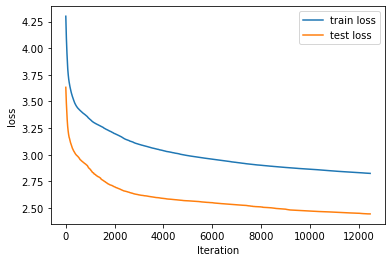

In [10]:
loss_train = results['train']['rmse']
loss_test = results['test']['rmse']

fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('loss')
ax.plot(loss_train, label='train loss')
ax.plot(loss_test, label='test loss')
plt.legend()
plt.show()

In [11]:
best_iteration = model.best_iteration
train_score = results['train']['rmse'][best_iteration-1]
test_score = results['test']['rmse'][best_iteration-1]
print(f"best iteration: {best_iteration}")
print(f'best rmse score (train): {train_score}')
print(f'best rmse score (test) : {test_score}')

best iteration: 12419
best rmse score (train): 2.825244602162275
best rmse score (test) : 2.444234509227256


# Submission 用の数値を出そう

## 推定

In [9]:
# model.save_model('./lgb_1105.txt', num_iteration=model.best_iteration)
# model = lgb.Booster(model_file='lgb_1105.txt')

In [16]:
y_pred = model.predict(subm[features])
subm['num'] = y_pred

In [17]:
subm.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan
46881677,HOBBIES_1_001_CA_1_evaluation,1437,1942,0.512366,23,11617,3,5,2016,30,4,0,0,0,8.38,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881678,HOBBIES_1_002_CA_1_evaluation,1438,1942,0.487075,23,11617,3,5,2016,30,4,0,0,0,3.97,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881679,HOBBIES_1_003_CA_1_evaluation,1439,1942,0.574451,23,11617,3,5,2016,30,4,0,0,0,2.97,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881680,HOBBIES_1_004_CA_1_evaluation,1440,1942,1.192823,23,11617,3,5,2016,30,4,0,0,0,4.64,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
46881681,HOBBIES_1_005_CA_1_evaluation,1441,1942,0.611642,23,11617,3,5,2016,30,4,0,0,0,2.88,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## 提出様式へ変形

* validationは d_1914 - d_1941 の28日分
* evaluationは d_1942 - d_1969 の28日分　らしい

### validation

In [18]:
y_pred = model.predict(test[features])
test_pred = test.copy(deep=True)
test_pred['num'] = y_pred

In [19]:
out_valid = test_pred.pivot(index="id", columns="date_id", values="num").reset_index()
out_valid.columns = ["id"]+[f"F{str(i+1)}" for i in range(28)]

In [20]:
out_valid.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.437507,0.407721,0.420293,0.429136,0.607741,0.887259,0.855630,0.485022,0.480554,0.490560,0.533611,0.647599,0.929428,0.742066,0.481146,0.461677,0.483663,0.488873,0.652694,0.918730,0.886019,0.505155,0.468187,0.490098,0.495454,0.655338,0.917525,0.875804
1,FOODS_1_001_CA_2_validation,0.882479,0.737002,0.760773,0.783094,0.944242,1.448882,1.392363,0.952281,0.862724,0.847879,0.936224,1.018575,1.532344,1.284261,1.010495,0.833021,0.890934,0.908274,1.032889,1.526661,1.477535,0.999315,0.820592,0.841314,0.848566,0.973030,1.474021,1.384974
2,FOODS_1_001_CA_3_validation,0.936876,0.881282,0.831453,0.829828,0.921605,1.241687,1.285090,1.020603,1.004062,0.936802,1.021918,1.020295,1.343140,1.206577,1.063465,1.010554,0.921673,0.913803,0.977646,1.304641,1.303209,1.004884,0.943399,0.907173,0.905431,0.977968,1.291838,1.280096
3,FOODS_1_001_CA_4_validation,0.214543,0.226808,0.236631,0.244688,0.302308,0.343818,0.262914,0.197957,0.230817,0.234212,0.283398,0.275411,0.310537,0.182925,0.209141,0.228674,0.241189,0.246437,0.291260,0.324927,0.320593,0.235826,0.249681,0.264767,0.271444,0.317355,0.343425,0.330246
4,FOODS_1_001_TX_1_validation,0.152230,0.162068,0.173623,0.178813,0.263787,0.357081,0.360533,0.169345,0.234510,0.209985,0.294628,0.307471,0.385695,0.257925,0.210478,0.196452,0.255914,0.266738,0.332537,0.379431,0.410247,0.210171,0.211756,0.232891,0.235476,0.309013,0.372439,0.365558


In [21]:
del test_pred

### evaluation

In [22]:
out_eval = subm.pivot(index="id", columns="date_id", values="num").reset_index()
out_eval.columns = ["id"]+[f"F{str(i+1)}" for i in range(28)]

In [23]:
out_eval.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.495456,0.429218,0.429958,0.439470,0.591027,0.843226,0.798079,0.531133,0.457181,0.485909,0.491226,0.722951,0.943626,0.889185,0.501722,0.480646,0.499996,0.493051,0.662167,0.930529,0.883952,0.501974,0.472882,0.506420,0.517193,0.669649,0.944727,0.824645
1,FOODS_1_001_CA_2_evaluation,0.934730,0.758498,0.758883,0.781872,0.925859,1.412163,1.325758,1.000150,0.796823,0.842070,0.839342,1.070248,1.524239,1.471214,1.016431,0.863652,0.867476,0.911587,1.014328,1.560635,1.479022,1.020424,0.858531,0.918260,0.908798,1.011044,1.520405,1.326143
2,FOODS_1_001_CA_3_evaluation,0.988195,0.903063,0.845666,0.851621,0.916499,1.210343,1.197879,1.036000,0.919021,0.945880,0.945436,1.132465,1.354675,1.350891,1.056767,1.002204,0.992621,0.997723,1.067338,1.336118,1.312475,1.009565,0.963751,0.939842,0.939007,1.002745,1.327496,1.221415
3,FOODS_1_001_CA_4_evaluation,0.243249,0.233749,0.242111,0.249926,0.291709,0.312399,0.298464,0.298803,0.278054,0.222145,0.231804,0.335359,0.326833,0.307198,0.211290,0.228006,0.243237,0.250136,0.300929,0.333554,0.318306,0.222773,0.238800,0.263121,0.280747,0.327654,0.357139,0.291993
4,FOODS_1_001_TX_1_evaluation,0.197921,0.183849,0.184589,0.190163,0.255163,0.310727,0.300397,0.214934,0.201283,0.233077,0.215164,0.367448,0.370171,0.382525,0.213571,0.232037,0.222765,0.258575,0.299514,0.414511,0.405504,0.231468,0.220201,0.284922,0.256197,0.321084,0.387788,0.354333


### ファイルを作成

In [24]:
out_sub = pd.read_csv("./data/sample_submission.csv")

In [25]:
out_sub.set_index("id", drop=False, inplace=True)
out_valid.set_index("id", drop=False, inplace=True)
out_eval.set_index("id", drop=False, inplace=True)

out_sub.update(out_valid)
out_sub.update(out_eval)

In [27]:
out_sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001_CA_1_validation,0.499099,0.445156,0.437480,0.441391,0.546935,0.643140,0.685957,0.538465,0.492662,0.484310,0.435780,0.558825,0.686014,0.558212,0.507877,0.471072,0.450686,0.450531,0.548333,0.658899,0.678767,0.521735,0.467351,0.471255,0.472049,0.563680,0.664777,0.683003
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002_CA_1_validation,0.490567,0.423631,0.415954,0.419866,0.555098,0.665946,0.707600,0.522794,0.461093,0.455200,0.397537,0.538362,0.709590,0.541425,0.494139,0.441962,0.419117,0.418962,0.531774,0.677038,0.696906,0.504606,0.432702,0.436606,0.436380,0.543796,0.670833,0.689059
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003_CA_1_validation,0.544410,0.456384,0.437501,0.441413,0.578382,0.744150,0.806729,0.612724,0.523838,0.516208,0.413371,0.594106,0.803125,0.613407,0.574513,0.508014,0.473125,0.472969,0.587518,0.778294,0.791000,0.591981,0.498989,0.497848,0.497622,0.606775,0.783911,0.791375
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004_CA_1_validation,1.131668,1.021961,1.003078,1.006990,1.123857,1.452830,1.562056,1.230346,1.129117,1.112899,1.047989,1.191322,1.559203,1.397627,1.202225,1.104706,1.079155,1.078999,1.184734,1.526565,1.548610,1.210354,1.095680,1.094539,1.094314,1.194652,1.532183,1.539646
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005_CA_1_validation,0.582047,0.498404,0.479521,0.483433,0.620402,0.781788,0.852135,0.649916,0.573627,0.557782,0.463606,0.643895,0.848531,0.651045,0.619920,0.549588,0.522913,0.522758,0.637307,0.815485,0.836406,0.629173,0.540563,0.539422,0.539196,0.648349,0.821103,0.828566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,1.794099,1.698100,1.694912,1.700762,1.835062,2.098793,2.078867,1.906090,1.710688,1.716537,1.917032,2.127944,2.307089,2.419201,2.028583,1.781819,1.934266,1.930389,1.951357,2.432271,2.423253,1.881069,1.930429,1.960928,1.831961,1.939567,2.268844,2.082109
FOODS_3_824_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,0.523272,0.447780,0.447768,0.453618,0.587658,0.844875,0.824949,0.639494,0.463544,0.541519,0.724500,0.956944,0.999534,1.139095,0.833987,0.600316,0.734281,0.752295,0.745926,1.152165,1.143147,0.680915,0.730444,0.782834,0.620190,0.689173,0.953668,0.771986
FOODS_3_825_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,1.213161,1.147890,1.176152,1.181435,1.311564,1.515375,1.495449,1.361624,1.191928,1.183989,1.365004,1.589167,1.641783,1.773157,1.460539,1.242935,1.376120,1.390266,1.388473,1.786228,1.777210,1.313024,1.372283,1.422044,1.273247,1.378186,1.605041,1.472649


# 記録・保存

In [28]:
id_ = "1108_2300"
comment = "more params tuned from 2nd submission"

In [38]:
flag = 1
i = 0
with open("./report.txt") as f:
    lines = f.readlines()
    while flag==1:
        flag = 0
        for l in lines:
            if l.startswith(id_):
                print(f'ID:{id_} has already been used!')
                flag = 1
                id_ = f"{id_}({i})"
                break
        i += 1

# save logs
f = open('./report.txt', 'a')
f.write(f'{id_}: comment  ... {comment}\n')
f.write(f'{id_}: features ... {features}\n')
f.write(f'{id_}: params1  ... {params}\n')
f.write(f'{id_}: score    ... iter={best_iteration}, train={train_score}, test={test_score}\n')
f.close()
# save submission files
out_sub.to_csv(f'./submission/submission_{id_}.csv', index=False)
# save scores
tmp = pd.read_csv('./scores.csv')
tmp_se = pd.Series([id_, best_iteration, train_score, test_score], index=tmp.columns)
tmp = tmp.append(tmp_se, ignore_index=True)
tmp.to_csv("./scores.csv", index=False)
# save models
model.save_model(f'./lgb_{id_}.txt', num_iteration=model.best_iteration)

1108_1906


# 特徴量の重要度
[【初心者向け】特徴量重要度の算出 (LightGBM) 【Python】【機械学習】](https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/)

In [2]:
model = lgb.Booster(model_file='lgb_1105.txt')

<AxesSubplot:ylabel='feature'>

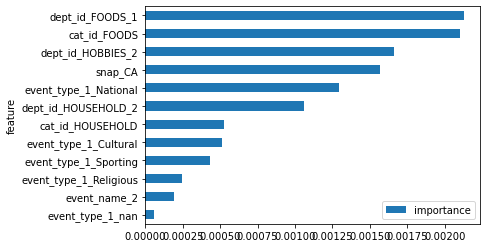

In [14]:
cols = ['item_id', 'date_id', 'date', 'wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'dept_id_FOODS_1', 'dept_id_FOODS_2', 'dept_id_FOODS_3', 'dept_id_HOBBIES_1', 'dept_id_HOBBIES_2', 'dept_id_HOUSEHOLD_1', 'dept_id_HOUSEHOLD_2', 'cat_id_FOODS', 'cat_id_HOBBIES', 'cat_id_HOUSEHOLD', 'store_id_CA_1', 'store_id_CA_2', 'store_id_CA_3', 'store_id_CA_4', 'store_id_TX_1', 'store_id_TX_2', 'store_id_TX_3', 'store_id_WI_1', 'store_id_WI_2', 'store_id_WI_3', 'state_id_CA', 'state_id_TX', 'state_id_WI', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting', 'event_type_1_nan']
f_importance = np.array(model.feature_importance())
f_importance = f_importance / np.sum(f_importance)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=True)
df_importance[:12].plot.barh(x="feature", y="importance")

<AxesSubplot:ylabel='feature'>

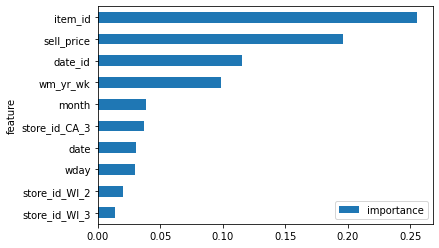

In [15]:
df_importance[-10:].plot.barh(x="feature", y="importance")

In [4]:
f_importance

array([2.73935169e-01, 1.22031110e-01, 2.63260563e-02, 6.35133072e-02,
       2.47468322e-02, 2.99017862e-02, 5.88604482e-04, 4.06764711e-03,
       2.96846641e-04, 3.68089834e-04, 2.10676301e-03, 4.70544332e-03,
       2.31670992e-01, 1.69626652e-03, 7.08530524e-03, 1.34446084e-02,
       2.95828881e-03, 2.07283768e-03, 7.19725883e-03, 6.49670076e-04,
       1.30612522e-03, 2.02703849e-03, 1.37397588e-04, 1.16007667e-02,
       1.10087697e-02, 4.15585297e-02, 9.59747596e-03, 4.88355130e-03,
       7.68239106e-03, 7.24475430e-03, 1.16703136e-02, 2.18038098e-02,
       1.29950978e-02, 1.06729089e-02, 1.26151341e-02, 1.12784761e-02,
       6.14048479e-04, 1.14497990e-03, 2.25603447e-04, 5.56375418e-04,
       1.35701321e-05])